In [1]:
import pandas as pd
import os
import lightgbm as lgbm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

### Read in Data

In [3]:
train = pd.read_csv('train.csv')
train.head()

user_id  user_num_orders  user_num_prods  user_num_distinct_prods  \
0        1               10              59                       18   
1    11192               21             192                       37   
2    12100                7              19                        4   
3    25303                9             275                      141   
4    26923               55             195                       21   

   user_avg_num_prods  user_avg_interval  user_dow_std  user_hour_std  \
0            5.900000             17.600         1.270          3.592   
1            9.142857             14.520         1.641          4.890   
2            2.714286             20.280         0.951          3.055   
3           30.555556              7.223         2.049          7.380   
4            3.545455              6.363         1.067          2.215   

   user_dow_median  user_hour_median  ...  prod_dow_median  prod_hour_median  \
0              2.5               8.5  ...              3.0              12.0   
1              3.0              13.0  ...              3.0              12.0   
2              4.0              15.0  ...              3.0              12.0   
3              1.0               8.0  ...              3.0              12.0   
4              1.0              11.0  ...              3.0              12.0   

   prod_dow_most  prod_hour_most  order_dow  order_hour_of_day  \
0              1              10          4                  8   
1              1              10          4                  8   
2              1              10          4                  8   
3              1              10          4                  8   
4              1              10          4                  8   

   days_since_prior_order  t_dow_orders  t_hour_orders  reordered  
0                    14.0       3787215        1719973        1.0  
1                    30.0       3787215        1719973        0.0  
2                    22.0       3787215        1719973        1.0  
3                    30.0       3787215        1719973        0.0  
4                    10.0       3787215        1719973        0.0  

[5 rows x 47 columns]

In [4]:
# reset the index
#setting user_id and product_id as index, since not used for features 
train = train.set_index(['user_id', 'product_id'])
train.head()

user_num_orders  user_num_prods  user_num_distinct_prods  \
user_id product_id                                                             
1       196                      10              59                       18   
11192   196                      21             192                       37   
12100   196                       7              19                        4   
25303   196                       9             275                      141   
26923   196                      55             195                       21   

                    user_avg_num_prods  user_avg_interval  user_dow_std  \
user_id product_id                                                        
1       196                   5.900000             17.600         1.270   
11192   196                   9.142857             14.520         1.641   
12100   196                   2.714286             20.280         0.951   
25303   196                  30.555556              7.223         2.049   
26923   196                   3.545455              6.363         1.067   

                    user_hour_std  user_dow_median  user_hour_median  \
user_id product_id                                                     
1       196                 3.592              2.5               8.5   
11192   196                 4.890              3.0              13.0   
12100   196                 3.055              4.0              15.0   
25303   196                 7.380              1.0               8.0   
26923   196                 2.215              1.0              11.0   

                    user_dow_most  ...  prod_dow_median  prod_hour_median  \
user_id product_id                 ...                                      
1       196                     1  ...              3.0              12.0   
11192   196                     3  ...              3.0              12.0   
12100   196                     4  ...              3.0              12.0   
25303   196                     1  ...              3.0              12.0   
26923   196                     1  ...              3.0              12.0   

                    prod_dow_most  prod_hour_most  order_dow  \
user_id product_id                                             
1       196                     1              10          4   
11192   196                     1              10          4   
12100   196                     1              10          4   
25303   196                     1              10          4   
26923   196                     1              10          4   

                    order_hour_of_day  days_since_prior_order  t_dow_orders  \
user_id product_id                                                            
1       196                         8                    14.0       3787215   
11192   196                         8                    30.0       3787215   
12100   196                         8                    22.0       3787215   
25303   196                         8                    30.0       3787215   
26923   196                         8                    10.0       3787215   

                    t_hour_orders  reordered  
user_id product_id                            
1       196               1719973        1.0  
11192   196               1719973        0.0  
12100   196               1719973        1.0  
25303   196               1719973        0.0  
26923   196               1719973        0.0  

[5 rows x 45 columns]

In [6]:
#train_fea = train.iloc[:,[12,41,31,19,4,16,3,29,25,32,2,11,18,21,22,6,28,5,33,34,30,0,13,44]]
#print(train_fea.shape)
#train_fea.head()

(8474661, 24)


user_reorder_ratio  days_since_prior_order  \
user_id product_id                                               
1       196                     0.6950                    14.0   
11192   196                     0.8070                    30.0   
12100   196                     0.7896                    22.0   
25303   196                     0.4873                    30.0   
26923   196                     0.8920                    10.0   

                    prod_reorder_rate  spec_order_ratio  user_avg_interval  \
user_id product_id                                                           
1       196                   0.77648            1.0000             17.600   
11192   196                   0.77648            0.1250             14.520   
12100   196                   0.77648            0.6665             20.280   
25303   196                   0.77648            0.4443              7.223   
26923   196                   0.77648            0.1091              6.363   

                    spec_perc_order  user_avg_num_prods  prod_num_orders  \
user_id product_id                                                         
1       196                  1.0000            5.900000            35791   
11192   196                  0.0952            9.142857            35791   
12100   196                  0.5713            2.714286            35791   
25303   196                  0.4443           30.555556            35791   
26923   196                  0.1091            3.545455            35791   

                    spec_num_last5  prod_avg_interval  ...  spec_avg_interval  \
user_id product_id                                     ...                      
1       196                    5.0             11.195  ...             17.600   
11192   196                    1.0             11.195  ...             27.500   
12100   196                    3.0             11.195  ...             26.500   
25303   196                    2.0             11.195  ...              6.750   
26923   196                    0.0             11.195  ...              4.332   

                    user_hour_std  department_id  user_dow_std  prod_dow_std  \
user_id product_id                                                             
1       196                 3.592              7         1.270         1.765   
11192   196                 4.890              7         1.641         1.765   
12100   196                 3.055              7         0.951         1.765   
25303   196                 7.380              7         2.049         1.765   
26923   196                 2.215              7         1.067         1.765   

                    prod_hour_std  prod_reorder_times  user_num_orders  \
user_id product_id                                                       
1       196                 3.727               27791               10   
11192   196                 3.727               27791               21   
12100   196                 3.727               27791                7   
25303   196                 3.727               27791                9   
26923   196                 3.727               27791               55   

                    spec_last_reorder_status  reordered  
user_id product_id                                       
1       196                              1.0        1.0  
11192   196                              0.0        0.0  
12100   196                              1.0        1.0  
25303   196                              1.0        0.0  
26923   196                              0.0        0.0  

[5 rows x 24 columns]

In [7]:
test = pd.read_csv('test.csv')
test.head()

user_id  user_num_orders  user_num_prods  user_num_distinct_prods  \
0     8942                4              56                       38   
1    24280               18              27                       14   
2    34207                3               5                        4   
3    42970                3              16                       12   
4    60073               35             365                      126   

   user_avg_num_prods  user_avg_interval  user_dow_std  user_hour_std  \
0           14.000000              21.25         1.414          4.360   
1            1.500000              17.39         1.382          2.635   
2            1.666667               3.00         1.000          2.518   
3            5.333333              19.67         0.577          7.023   
4           10.428571               9.80         2.693          4.668   

   user_dow_median  user_hour_median  ...  prod_hour_std  prod_dow_median  \
0              3.5               9.5  ...          3.727              3.0   
1              2.0              13.0  ...          3.727              3.0   
2              3.0               9.0  ...          3.727              3.0   
3              5.0              16.0  ...          3.727              3.0   
4              1.0              17.0  ...          3.727              3.0   

   prod_hour_median  prod_dow_most  prod_hour_most  order_dow  \
0              12.0              1              10          4   
1              12.0              1              10          4   
2              12.0              1              10          4   
3              12.0              1              10          4   
4              12.0              1              10          4   

   order_hour_of_day  days_since_prior_order  t_dow_orders  t_hour_orders  
0                  8                    30.0       3787215        1719973  
1                  8                     2.0       3787215        1719973  
2                  8                    21.0       3787215        1719973  
3                  8                    30.0       3787215        1719973  
4                  8                    11.0       3787215        1719973  

[5 rows x 46 columns]

In [8]:
test=test.set_index(['user_id','product_id'])
test.head()

user_num_orders  user_num_prods  user_num_distinct_prods  \
user_id product_id                                                             
8942    196                       4              56                       38   
24280   196                      18              27                       14   
34207   196                       3               5                        4   
42970   196                       3              16                       12   
60073   196                      35             365                      126   

                    user_avg_num_prods  user_avg_interval  user_dow_std  \
user_id product_id                                                        
8942    196                  14.000000              21.25         1.414   
24280   196                   1.500000              17.39         1.382   
34207   196                   1.666667               3.00         1.000   
42970   196                   5.333333              19.67         0.577   
60073   196                  10.428571               9.80         2.693   

                    user_hour_std  user_dow_median  user_hour_median  \
user_id product_id                                                     
8942    196                 4.360              3.5               9.5   
24280   196                 2.635              2.0              13.0   
34207   196                 2.518              3.0               9.0   
42970   196                 7.023              5.0              16.0   
60073   196                 4.668              1.0              17.0   

                    user_dow_most  ...  prod_hour_std  prod_dow_median  \
user_id product_id                 ...                                   
8942    196                     4  ...          3.727              3.0   
24280   196                     2  ...          3.727              3.0   
34207   196                     2  ...          3.727              3.0   
42970   196                     5  ...          3.727              3.0   
60073   196                     0  ...          3.727              3.0   

                    prod_hour_median  prod_dow_most  prod_hour_most  \
user_id product_id                                                    
8942    196                     12.0              1              10   
24280   196                     12.0              1              10   
34207   196                     12.0              1              10   
42970   196                     12.0              1              10   
60073   196                     12.0              1              10   

                    order_dow  order_hour_of_day  days_since_prior_order  \
user_id product_id                                                         
8942    196                 4                  8                    30.0   
24280   196                 4                  8                     2.0   
34207   196                 4                  8                    21.0   
42970   196                 4                  8                    30.0   
60073   196                 4                  8                    11.0   

                    t_dow_orders  t_hour_orders  
user_id product_id                               
8942    196              3787215        1719973  
24280   196              3787215        1719973  
34207   196              3787215        1719973  
42970   196              3787215        1719973  
60073   196              3787215        1719973  

[5 rows x 44 columns]

In [9]:
#test_fea = test.iloc[:,[12,41,31,19,4,16,3,29,25,32,2,11,18,21,22,6,28,5,33,34,30,0,13]]
#print(test_fea.shape)
#test_fea.head()

(4833292, 23)


user_reorder_ratio  days_since_prior_order  \
user_id product_id                                               
8942    196                     0.3215                    30.0   
24280   196                     0.4814                     2.0   
34207   196                     0.2000                    21.0   
42970   196                     0.2500                    30.0   
60073   196                     0.6550                    11.0   

                    prod_reorder_rate  spec_order_ratio  user_avg_interval  \
user_id product_id                                                           
8942    196                   0.77648            1.0000              21.25   
24280   196                   0.77648            0.1666              17.39   
34207   196                   0.77648            0.6665               3.00   
42970   196                   0.77648            1.0000              19.67   
60073   196                   0.77648            0.1111               9.80   

                    spec_perc_order  user_avg_num_prods  prod_num_orders  \
user_id product_id                                                         
8942    196                 0.25000           14.000000            35791   
24280   196                 0.05554            1.500000            35791   
34207   196                 0.66650            1.666667            35791   
42970   196                 0.33330            5.333333            35791   
60073   196                 0.05713           10.428571            35791   

                    spec_num_last5  prod_avg_interval  ...  spec_avg_cart_seq  \
user_id product_id                                     ...                      
8942    196                    1.0             11.195  ...                8.0   
24280   196                    0.0             11.195  ...                1.0   
34207   196                    2.0             11.195  ...                2.0   
42970   196                    1.0             11.195  ...                2.0   
60073   196                    1.0             11.195  ...               10.5   

                    spec_avg_interval  user_hour_std  department_id  \
user_id product_id                                                    
8942    196                      30.0          4.360              7   
24280   196                      22.0          2.635              7   
34207   196                       4.0          2.518              7   
42970   196                      29.0          7.023              7   
60073   196                      10.5          4.668              7   

                    user_dow_std  prod_dow_std  prod_hour_std  \
user_id product_id                                              
8942    196                1.414         1.765          3.727   
24280   196                1.382         1.765          3.727   
34207   196                1.000         1.765          3.727   
42970   196                0.577         1.765          3.727   
60073   196                2.693         1.765          3.727   

                    prod_reorder_times  user_num_orders  \
user_id product_id                                        
8942    196                      27791                4   
24280   196                      27791               18   
34207   196                      27791                3   
42970   196                      27791                3   
60073   196                      27791               35   

                    spec_last_reorder_status  
user_id product_id                            
8942    196                              0.0  
24280   196                              0.0  
34207   196                              1.0  
42970   196                              0.0  
60073   196                              1.0  

[5 rows x 23 columns]

#### * Note : Feature Engineering and Model Tuning done seperately. Not shown in this kernel.

### Building Model

In [14]:
#importing the necessary packages.
import random
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import f1_score, classification_report,confusion_matrix

X = train_fea.drop('reordered', axis=1)
y = train_fea.reordered
#X = oversampled_train.values
#y = oversampled_train.Reordered.values

random.seed(30)
#splitting train dataset into train and test split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#print(y.value_counts()) # check if the data is imbalanced or not. ratio = 9.22 --  very imbalanced

#Initializing the model
#lgb = lgb.LGBMClassifier(objective='binary')#, num_leaves=96, max_depth=10)
T = len(y)
P = 828824
weight = T/P - 1
print("scale_pos_weight:" + str(weight))
lgb = lgbm.LGBMClassifier(objective='binary',max_depth=6,num_leaves=56,
                          learning_rate=0.19,scale_pos_weight = weight,
                         min_data_in_leaf=300,n_jobs=2,boosting_type='goss',max_bin=100,num_iterations=1000) # Abdul Parameters

scale_pos_weight:9.22492229954731


In [13]:
#(T-P)

7645837

In [15]:
lgb.fit(X_train,y_train)
y_pred_test = (lgb.predict_proba(X_test)[:, 1] >= 0.7).astype('int') #setting a threshold.

C:\Users\Administrator\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


### Model Evaluation

F1 Score: 0.4465716040467998
              precision    recall  f1-score   support

           0       0.91      0.95      0.93   1471675
           1       0.52      0.39      0.45    223258

    accuracy                           0.87   1694933
   macro avg       0.72      0.67      0.69   1694933
weighted avg       0.86      0.87      0.86   1694933

[[1392677  136367]
 [  78998   86891]]


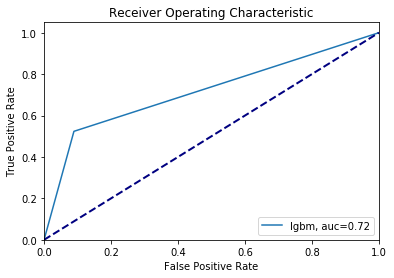

In [17]:
import sklearn.metrics as metrics
print('F1 Score: {}'.format(f1_score(y_pred_test, y_test)))
print(classification_report(y_pred_test, y_test))
print(confusion_matrix(y_test,y_pred_test))

accuracy_score(y_test, y_pred_test)

fpr, tpr, _ = roc_curve(y_test, y_pred_test)
roc_auc = metrics.auc(fpr, tpr)

%matplotlib inline
plt.plot(fpr,tpr,label="lgbm, auc="+str(format(roc_auc,'.2f')))
#plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.show()


#setting a threshold.

### Fit Entire Training Data

In [73]:
lgb.fit(X, y)
y_test_final = (lgb.predict_proba(test_fea)[:, 1] >= 0.7).astype('int') 

### Fit Test Data for Kaggle Submission

In [74]:
test_fea['prediction'] = y_test_final
print(test_fea.head())
# Reset the index
sub = test_fea.reset_index()
# Keep only the required columns for submission
sub = sub[['product_id', 'user_id', 'prediction']]

print(sub.head())
orders = pd.read_csv('orders.csv')

orders_test = orders.loc[orders.eval_set == 'test', ['user_id', 'order_id']]
orders_test.head()

#merging our prediction with orders_test
sub = sub.merge(orders_test, on='user_id', how='left')
#sub.head()

#remove user_id column since it is not needed for submission dataset
sub = sub.drop('user_id', axis=1)

#convert product_id as integer
sub['product_id'] = sub.product_id.astype(int)


#sub.head()

# we loop through the orders, if product is reordered, we put it into the dictionay. 
# we are not considering the products that are not reordered for our submission.
to_dict = {}
for row in sub.itertuples():
    if row.prediction == 1:
        try:
            to_dict[row.order_id] += ' ' + str(row.product_id)  # if it is already in dictionary, we keep adding it
        except:
            to_dict[row.order_id] = str(row.product_id) # if the product first added into the dictionary

# if no products reordered in that order, we mark as 'None'
for order in sub.order_id:
    if order not in to_dict:
        to_dict[order] = 'None'
        

#Convert the dictionary into a DataFrame
final_sub = pd.DataFrame.from_dict(to_dict, orient='index')

#Reset index
final_sub.reset_index(inplace=True)
#Set column names
final_sub.columns = ['order_id', 'products']

#final_sub.head()

final_sub.to_csv('subfeakaggleAbdul_bin100_numiter1000.csv',index=False,header=True)

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


                    user_reorder_ratio  days_since_prior_order  \
user_id product_id                                               
8942    196                     0.3215                    30.0   
24280   196                     0.4814                     2.0   
34207   196                     0.2000                    21.0   
42970   196                     0.2500                    30.0   
60073   196                     0.6550                    11.0   

                    prod_reorder_rate  spec_order_ratio  user_avg_interval  \
user_id product_id                                                           
8942    196                   0.77648            1.0000              21.25   
24280   196                   0.77648            0.1666              17.39   
34207   196                   0.77648            0.6665               3.00   
42970   196                   0.77648            1.0000              19.67   
60073   196                   0.77648            0.1111              

In [23]:
lgb.booster_.feature_importance()

# importance of each attribute
fea_imp_ = pd.DataFrame({'cols':X_train.columns, 'fea_imp':lgb.feature_importances_})
fea_imp_.loc[fea_imp_.fea_imp > 0].sort_values(by=['fea_imp'], ascending = False)

cols  fea_imp
1      days_since_prior_order      472
0          user_reorder_ratio      441
3            spec_order_ratio      380
2           prod_reorder_rate      371
4           user_avg_interval      316
5             spec_perc_order      290
6          user_avg_num_prods      218
9           prod_avg_interval      211
7             prod_num_orders      205
12           spec_order_range      201
10    user_num_distinct_prods      185
14          spec_avg_interval      182
11  user_num_prods_last_order      178
8              spec_num_last5      170
17               user_dow_std      170
15              user_hour_std      169
18               prod_dow_std      165
13          spec_avg_cart_seq      159
16              department_id      147
21            user_num_orders      143
20         prod_reorder_times      130
19              prod_hour_std      120
22   spec_last_reorder_status      103

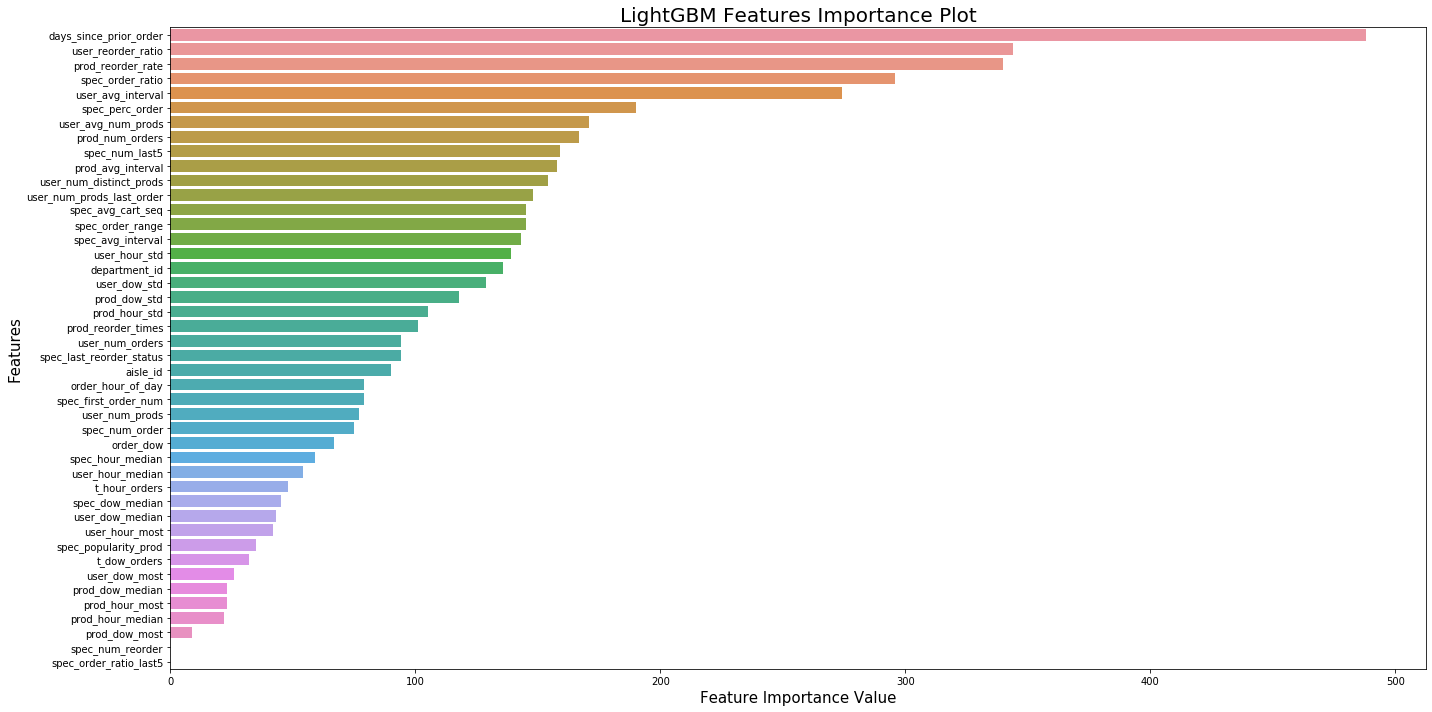

<Figure size 432x288 with 0 Axes>

In [13]:
#feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,X.columns)), columns=['Value','Feature'])
import seaborn as sns
plt.figure(figsize=(20, 10))
sns.barplot(x="fea_imp", y="cols", data=fea_imp_.sort_values(by="fea_imp", ascending=False))
plt.title('LightGBM Features Importance Plot',fontsize = 20)
plt.xlabel('Feature Importance Value',fontsize = 15)
plt.ylabel('Features',fontsize = 15)
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances.png')

### ---------------------------------------------------------